In [2]:
import yfinance as yf
import json
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import dates as mdates
import numpy as np 

%matplotlib inline

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (30, 10)

In [ ]:
stock_dir_path = str(Path(os.path.abspath('')).parents[0] / 'data/stock_data/')
tickers_path = str(Path(os.path.abspath('')).parents[0] / 'data/stocksTickers.json')

In [ ]:
tickers_path = str(Path(os.path.abspath('')).parents[0] / 'data/stocksTickers.json')
with open(tickers_path) as ticker_names: 
    names = json.load(ticker_names)

In [ ]:
def download_yfinance_data(names_dict, peroid='3y', dir_path=stock_dir_path): 

    for ticker_name, name in names_dict.items(): 
        ticker = yf.Ticker(ticker_name)
        data = ticker.history(period=peroid)
        data.to_csv(str(Path(dir_path) / f'{name.lower()}.csv'))

In [ ]:
# download_yfinance_data(names_dict=names)

In [ ]:
def load_all_stocks_data(stock_path=stock_dir_path):
    data_dict = {}
    for filename in os.listdir(stock_dir_path): 
        data_dict[filename.split('.')[0]] = pd.read_csv(str(Path(stock_path) / filename))
        
    return data_dict

In [ ]:
data_dict = load_all_stocks_data()

In [ ]:
def plot_all_prices(data_dict, x_col, y_col, one_figsize:list, minticks=20, maxticks=30): 
    
    number_of_plots = len(data_dict)
    _, axes = plt.subplots(number_of_plots, 1, figsize=(one_figsize[0], one_figsize[1] * number_of_plots))

    for ax, (company, data) in zip(axes, data_dict.items()):
        ax.plot(data[x_col], data[y_col])
        ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks))
        ax.set_title(f'{company.capitalize()} close stock price in past 3 years.', size=25)
        ax.set_xlabel('Time', size=15)
        ax.set_ylabel('Price in $', size=15)
    
    plt.show()

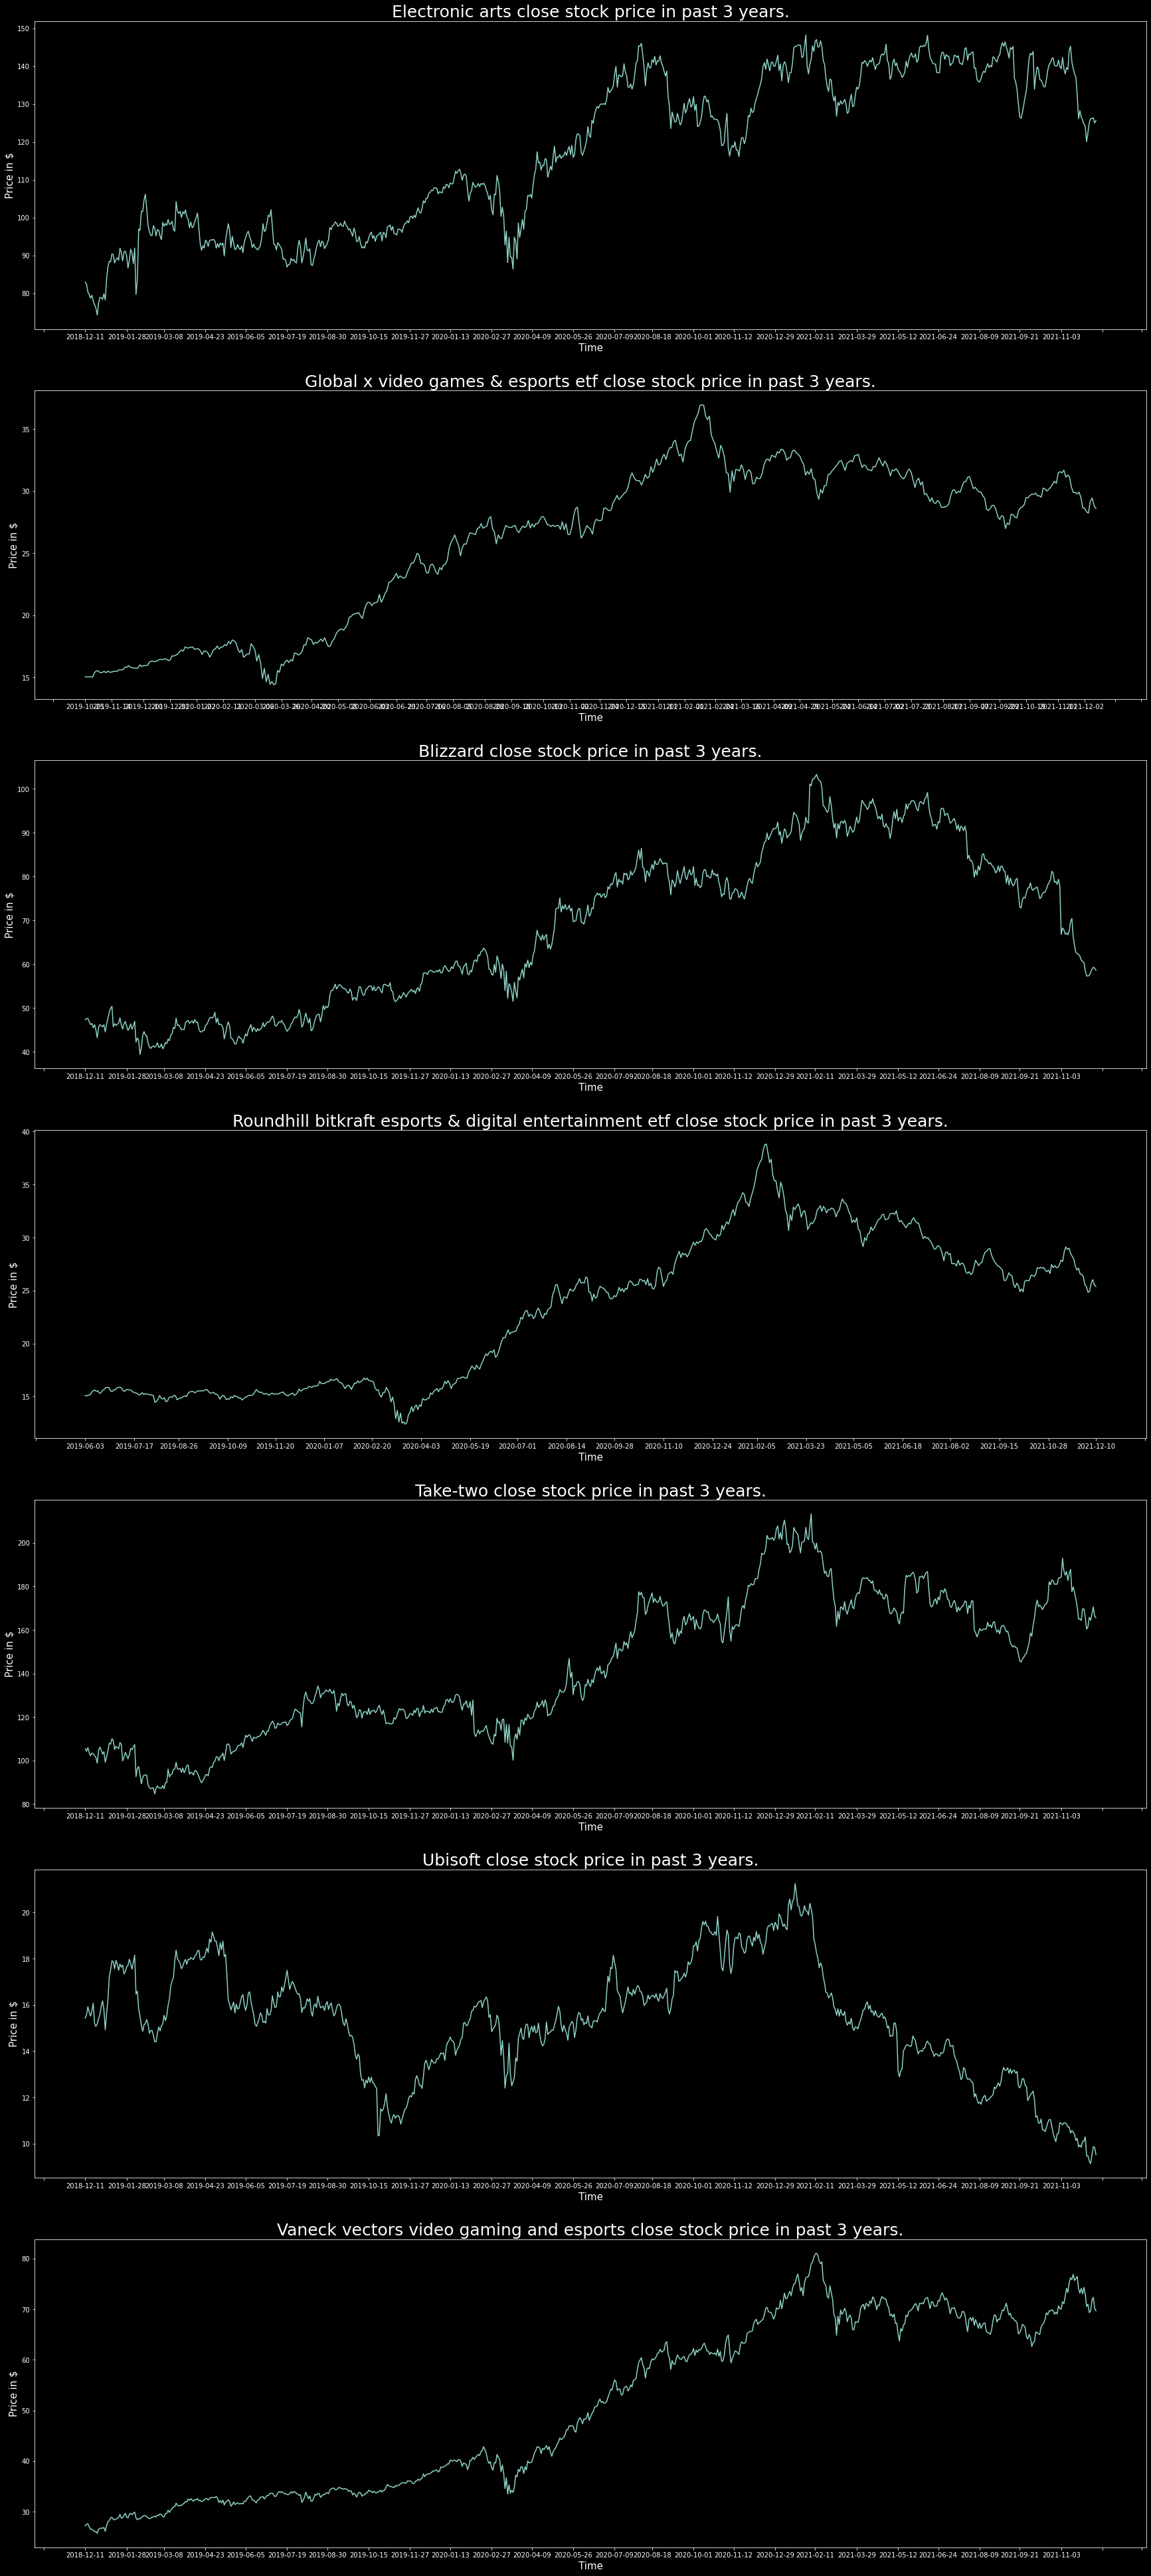

In [ ]:
plot_all_prices(data_dict, 'Date', 'Close', [30, 10])

# Preparation of Technical Indicators 

## 1. Moving averages 
    - Simple 
    - Exponential 
    - Weighted

In [ ]:
# data = pd.DataFrame(columns=data_dict['blizzard'].columns)
# for df in list(data_dict.values()): 
#     data.append(df)

# blizzard = data['blizzard']

In [ ]:
data_dict['electronic arts']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-12-11,84.585878,84.780943,82.210876,82.916420,3877038,0.00,0
1,2018-12-12,83.790887,84.834301,82.389738,82.469231,3400512,0.00,0
2,2018-12-13,83.383464,83.408301,80.273100,80.352600,5011120,0.00,0
3,2018-12-14,79.319120,81.435751,78.643485,79.656990,5227573,0.00,0
4,2018-12-17,79.637112,81.505312,77.987533,78.732826,4083459,0.00,0
...,...,...,...,...,...,...,...,...
752,2021-12-06,127.268483,127.637981,124.706933,126.139999,2863915,0.00,0
753,2021-12-07,127.250000,128.000000,125.930000,126.150002,2650223,0.17,0
754,2021-12-08,126.379997,127.324997,125.129997,126.370003,2553671,0.00,0
755,2021-12-09,126.489998,126.875000,124.690002,125.000000,2344271,0.00,0


# 2. Bollinger Bands

In [ ]:
def get_bollinger_bands(prices, peroid):
    sma = prices.rolling(window=peroid).mean()
    std = prices.rolling(peroid).std()
    bollinger_up = sma + std * 2 
    bollinger_down = sma - std * 2 
    return bollinger_up, bollinger_down

In [ ]:
# calculate moving averages 
peroid_list = [5, 10, 20, 50, 100]

for df in data_dict.values(): 
    for peroid in peroid_list: 
        df[f'sma_{peroid}'] = df['Close'].rolling(window=peroid).mean()
        df[f'ema_{peroid}'] = df['Close'].ewm(span=peroid).mean()
        
        weights = np.arange(1, peroid + 1)
        df[f'wma_{peroid}'] = (df['Close'].rolling(window=peroid)
                                          .apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True))

        bollinger_up, bollinger_down = get_bollinger_bands(df['Close'], peroid)
        df[f'bb_{peroid}_up'] = bollinger_up
        df[f'bb_{peroid}_down'] = bollinger_down


In [ ]:
def plot_bb(close, up, down):
    plt.title('Bollinger Bands')
    plt.xlabel('Days')
    plt.ylabel('Closing Prices')
    plt.plot(close, label='Closing Prices')
    plt.plot(up, label='Bollinger Up', c='y')
    plt.plot(down, label='Bollinger Down', c='b')
    plt.legend()
    plt.show()

In [ ]:
data_dict.keys()

dict_keys(['electronic arts', 'global x video games & esports etf', 'blizzard', 'roundhill bitkraft esports & digital entertainment etf', 'take-two', 'ubisoft', 'vaneck vectors video gaming and esports'])

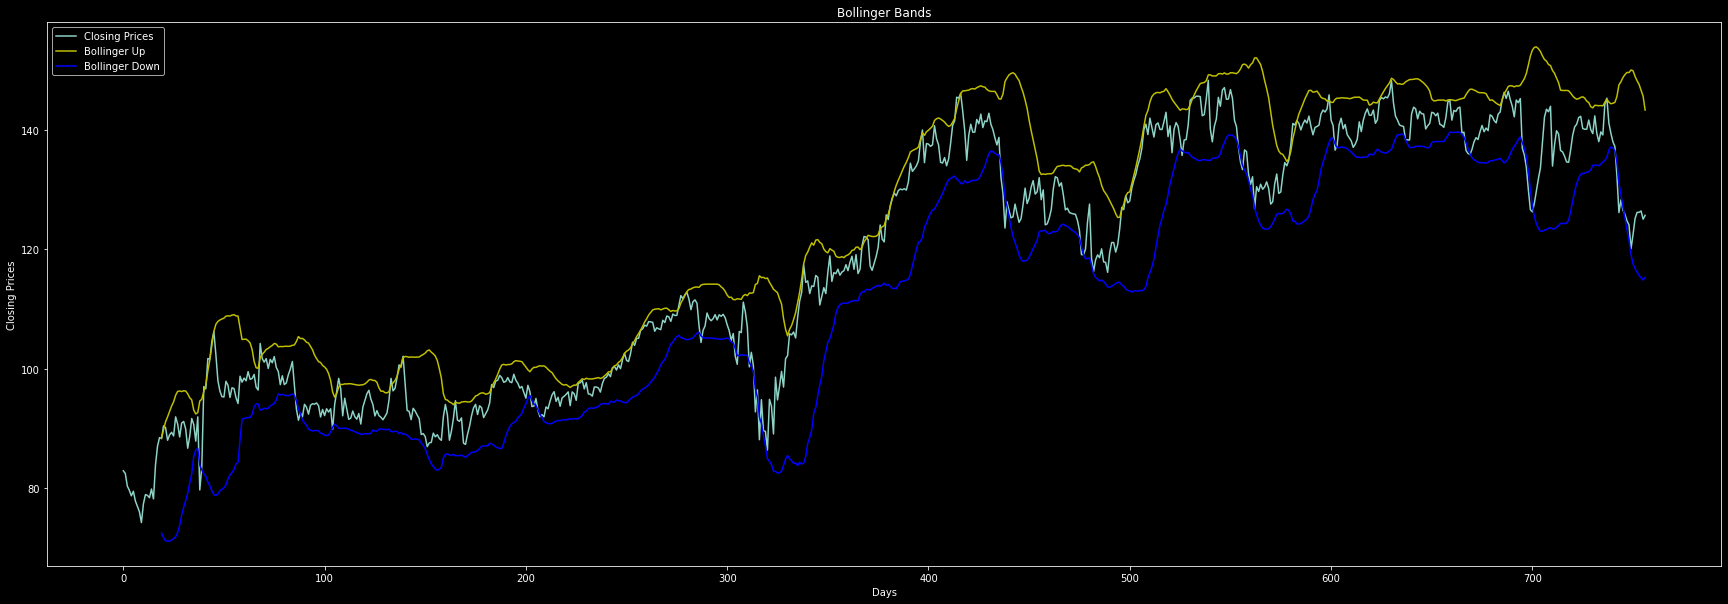

In [ ]:
plot_bb(data_dict['electronic arts']['Close'], data_dict['electronic arts']['bb_20_up'], data_dict['electronic arts']['bb_20_down'])

In [ ]:
df

NameError: name 'df' is not defined

In [ ]:
def plot_multiple_lines(title, close, list_of_lines): 
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Closing Prices')
    plt.plot(close, label='Closing Prices')
    for line_tuple in list_of_lines:
        plt.plot(line_tuple[0], label=line_tuple[1], c=line_tuple[2])
        
    plt.legend()
    plt.show()

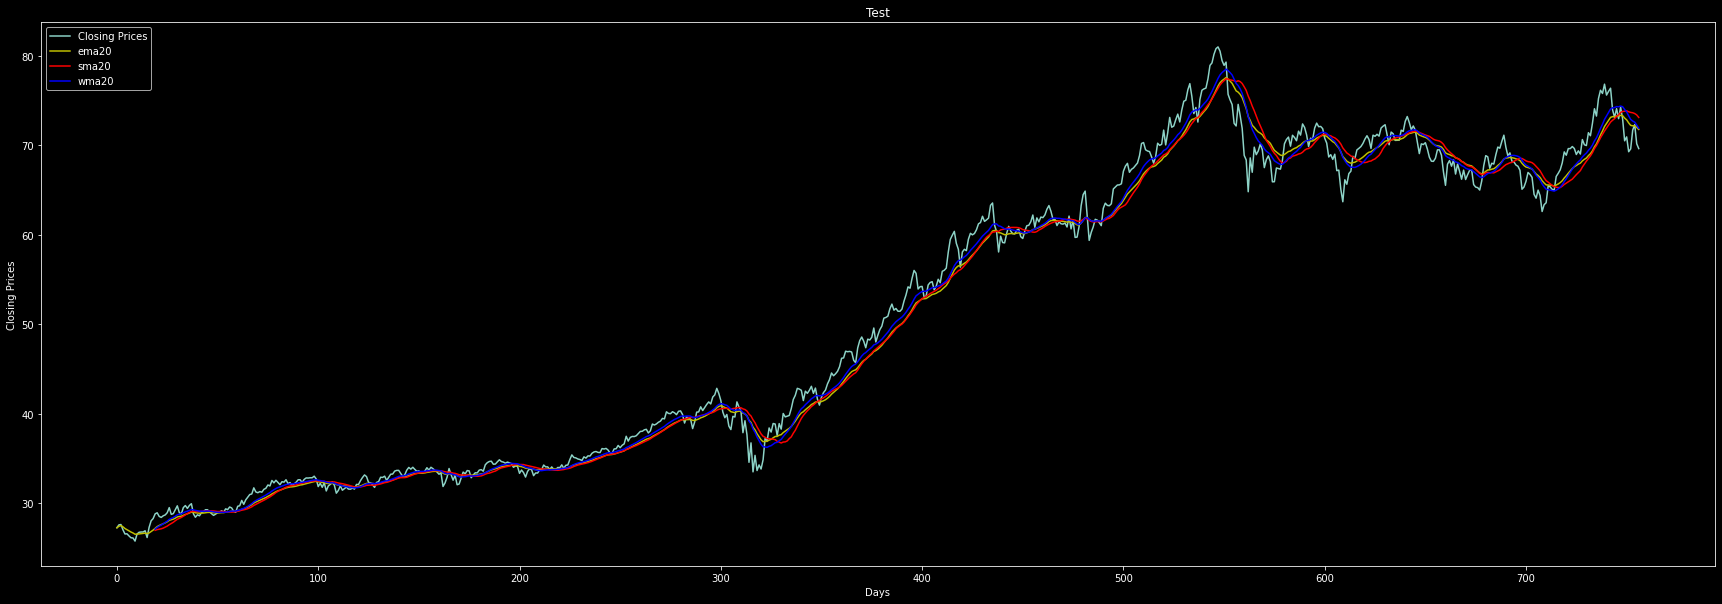

In [ ]:
plot_multiple_lines(
    'Test', 
    df['Close'], 
    [
        (df['ema_20'], 'ema20', 'y'), 
        (df['sma_20'], 'sma20', 'r'), 
        (df['wma_20'], 'wma20', 'b')
    ]
)

# 3. MACD

In [ ]:
def get_macd(prices): 
    exp12 = prices.ewm(span=12, adjust=False).mean()
    exp26 = prices.ewm(span=26, adjust=False).mean() 
    macd = exp12 - exp26 
    signal_line = macd.ewm(span=9, adjust=False).mean() 
    
    return macd, signal_line

In [ ]:
macd, signal_line = get_macd(data_dict['electronic arts']['Close'])

In [ ]:
signal_line

0      0.000000
1     -0.007135
2     -0.052120
3     -0.129452
4     -0.237452
         ...   
752   -3.428083
753   -3.533344
754   -3.569825
755   -3.575005
756   -3.541936
Name: Close, Length: 757, dtype: float64

In [ ]:
for df in data_dict.values():
    macd, signal_line = get_macd(df['Close'])
    df['macd'] = macd
    df['signal'] = signal_line

In [ ]:
data_dict['blizzard'].to_csv(str(Path(os.path.abspath('')).parents[0] / 'data/ea.csv'))

# 4 RSI 

In [ ]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]